# Table of Contents <a id='top'></a> 
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#functions)<br> 
3. [Conduct Experiments](#experiments)<br> 
4. [Visualize Results](#visualize)<br> 

---
## 1: Import Packages <a id='imports'></a> 
[jump to top](#top)<br>

In [1]:
# modules I created
from bidder import Bidder
from auction import Auction, User

# outside libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

--- 
## 2: Define Functions <a id='functions'></a> 
[jump to top](#top)<br>

In [2]:
def run_experiment(auction):
    for i in range(auction.bidders[0].num_rounds):
        auction.execute_round()

In [3]:
def overview(auction, game_state_id = None):
    """Given a completed auction (an auction object for which .execute() has been repeatedly called),
    summarize the attributes of the bidders involved and indicate the final balance of each bidder"""
    
    dicty = {"auction_id": [],
             "bidder_id": [],
             "bidder_type": [],
             "alpha": [],
             "aggressiveness": [],
             "under_cut": [],
             "num_users": [],
             "final_balance": []}

    for bidder in auction.bidders:
        dicty["auction_id"].append(auction.auction_id)
        dicty["bidder_id"].append(bidder.bidder_id)
        dicty["bidder_type"].append(bidder.bidder_type)
        if bidder.bidder_type == "smart":
            dicty["alpha"].append(bidder.alpha)
            dicty["aggressiveness"].append(bidder.aggressiveness)
            dicty["under_cut"].append(bidder.under_cut)
        else:
            dicty["alpha"].append("NA")
            dicty["aggressiveness"].append("NA")
            dicty["under_cut"].append("NA")
        dicty["num_users"].append(len(auction.users))
        dicty["final_balance"].append(auction.balances[bidder])

    summary_df = pd.DataFrame(dicty)
    
    if game_state_id != None:
        summary_df["game_state_id"] = [game_state_id for i in range(len(summary_df))]
        return summary_df[["auction_id"] + ["game_state_id"] + ["bidder_id", "bidder_type", "alpha", "aggressiveness", "under_cut", "num_users", "final_balance"]]
    else:
        return summary_df


--- 
## 3: Conduct Experiments <a id='experiments'></a> 
[jump to top](#top)<br>

In [4]:
alpha_levels = [i/10 for i in range(10)]
aggressiveness_levels = [i/20 for i in range(20)]
under_cut_levels = [i/20 for i in range(0, 5)]

In [5]:
dict_bidders = {"bidder_id":[], "alpha": [], "aggressiveness": [], "under_cut": []}

i = 0
for alpha in alpha_levels:
    for agg in aggressiveness_levels:
        for undercut in under_cut_levels:
            dict_bidders["bidder_id"].append(i)
            dict_bidders["alpha"].append(alpha)
            dict_bidders["aggressiveness"].append(agg)
            dict_bidders["under_cut"].append(undercut)
            i += 1
            
df_bidders = pd.DataFrame(dict_bidders)  
df_bidders["num_auctions_played"] = [0 for i in range(len(df_bidders))]
df_bidders["total_balance"] = [0 for i in range(len(df_bidders))]
# df_bidders["average_final_balance"] = df_bidders["total_balance"] / df_bidders["num_auctions_played"]
df_bidders['average_final_balance'] = df_bidders.apply(
    lambda row: row['total_balance'] / row['num_auctions_played'] if row['num_auctions_played'] != 0 else 0,
    axis=1
)
df_bidders

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
0,0,0.0,0.00,0.00,0,0,0
1,1,0.0,0.00,0.05,0,0,0
2,2,0.0,0.00,0.10,0,0,0
3,3,0.0,0.00,0.15,0,0,0
4,4,0.0,0.00,0.20,0,0,0
...,...,...,...,...,...,...,...
995,995,0.9,0.95,0.00,0,0,0
996,996,0.9,0.95,0.05,0,0,0
997,997,0.9,0.95,0.10,0,0,0
998,998,0.9,0.95,0.15,0,0,0


**So I want to track the performance of each of these bidders across different combinations of other bidders as well as num_users**

My idea right now is to randomly draw a random number of bidders from that data frame ^ and run an auction with them. Then I will repeat this over and over again until each bidder has been selected like 10 times (?). 

In [6]:
def run_record_auction():
    """Do it all"""
    
    # instantiate 10 users
    users = [User() for i in range(10)]
    
    # decide how many smart bidders will participate, it will be anywhere from 5 to 9
    num_bidders = np.random.randint(5, 10)

    # randomly select bidders from the table df_bidders 
    bidders_ids = np.random.choice(df_bidders.index, num_bidders)
    
    # instantiate the bidders with the attributes defined in the df_bidders table
    bidders = [Bidder(num_users=10, num_rounds=1000, bidder_type="zero")] + [Bidder(10, 1000, bidder_id = bidders_ids[i], bidder_type="smart", alpha=df_bidders.loc[bidders_ids[i]][1], aggressiveness=df_bidders.loc[bidders_ids[i]][2], under_cut=df_bidders.loc[bidders_ids[i]][3]) for i in range(num_bidders)] + [Bidder(num_users=10, num_rounds=1000, bidder_type="random")]
    
    # instantiate the auction with the users and bidders created above
    auction = Auction(users, bidders, 127)
    
    # execute 1000 rounds of the auction
    run_experiment(auction)
    
    # summarize the outcome of the auction
    overview_df = overview(auction, game_state_id=33)
    
    # record the results of the auction in the df_bidders dataframe
    smart_bidders_df = overview_df[overview_df["bidder_type"]=="smart"]
    smart_bidders_df = smart_bidders_df.reset_index()
    for i in range(len(smart_bidders_df)):
        final_balance = smart_bidders_df.loc[i, "final_balance"]
        bidder_id = smart_bidders_df.loc[i, "bidder_id"]
        df_bidders.loc[bidder_id, "total_balance"] += final_balance
        df_bidders.loc[bidder_id, "num_auctions_played"] += 1
        df_bidders.loc[bidder_id, "average_final_balance"] = df_bidders.loc[bidder_id, "total_balance"] / df_bidders.loc[bidder_id, "num_auctions_played"]

In [7]:
# run the experiment many times and time how long it takes

import time

a = time.time()

for i in range(4000):
    run_record_auction()

b = time.time()

print(round(b-a, 2), "seconds")

63.5 seconds


In [8]:
# see which bidders are doing best and worst 

df_bidders.loc[df_bidders.num_auctions_played>0].sort_values(by="average_final_balance", ascending=False)

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
185,185,0.1,0.85,0.00,27,851.744378,31.546088
177,177,0.1,0.75,0.10,19,544.569423,28.661549
366,366,0.3,0.65,0.05,22,569.479688,25.885440
285,285,0.2,0.85,0.00,20,510.588930,25.529446
272,272,0.2,0.70,0.10,34,825.525111,24.280150
...,...,...,...,...,...,...,...
799,799,0.7,0.95,0.20,24,-3977.589026,-165.732876
899,899,0.8,0.95,0.20,33,-5486.187831,-166.248116
996,996,0.9,0.95,0.05,30,-5238.161838,-174.605395
999,999,0.9,0.95,0.20,31,-5709.603734,-184.180766


In [9]:
# this cell is just to find out the min and max of num_auctions_played in order to make a good histogram below

df_bidders[["num_auctions_played"]].describe()

,num_auctions_played
count,1000.0000
mean,27.8620
std,5.5239
min,12.0000
25%,24.0000
50%,28.0000
75%,32.0000
max,53.0000


In [16]:
type(df_bidders[["num_auctions_played"]].describe().loc["min", "num_auctions_played"])

numpy.float64

(array([ 1.,  0.,  3.,  2.,  9.,  9., 16., 19., 28., 39., 48., 43., 60.,
        64., 73., 73., 70., 62., 74., 52., 50., 52., 39., 30., 24., 19.,
        15.,  7.,  3.,  6.,  5.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.]),
 array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
        51., 52., 53.]),
 <BarContainer object of 41 artists>)

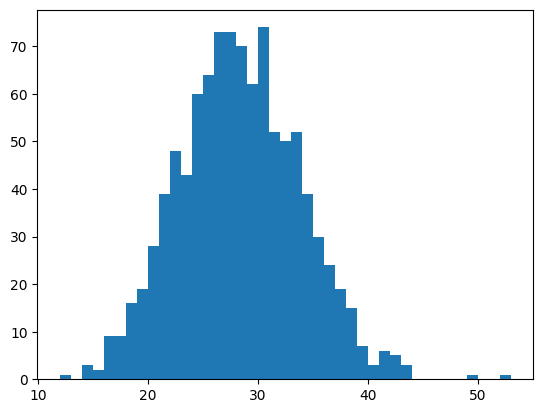

In [17]:
# look at the full distribution of num_auctions_played

min_ = df_bidders[["num_auctions_played"]].describe().loc["min", "num_auctions_played"]
max_ = df_bidders[["num_auctions_played"]].describe().loc["max", "num_auctions_played"]

plt.hist(df_bidders.num_auctions_played, bins=int(max_-min_))

It might take about a minute to run enough simulations that very few bidders have fewer than 10 auctions played. Getting the *minimum* to 10 might take a long time though. <br>
*Update:* It only took a minute to get the min to 12.

--- 
## 4: Visualize Results <a id='visualize'></a> 
[jump to top](#top)<br>

**Visualization idea: scatter plot of all the bidders with alpha on one axis, aggressiveness on the other, and they are colored by their average_final_balance**

In [35]:
# remember how I created the bidders? at incremements of 0.05. This means that if you scatter only two of the 
# three attributes (alpha, aggressiveness, under_cut) you will have overlapping values

# address the problem by averaging over the third attribute
test_df = pd.DataFrame(df_bidders.groupby(["alpha", "aggressiveness"])["average_final_balance"].mean())
test_df = test_df.reset_index()
test_df.sort_values(by="average_final_balance", ascending=False)

,alpha,aggressiveness,average_final_balance
35,0.1,0.75,15.543336
54,0.2,0.70,13.322374
37,0.1,0.85,13.255604
75,0.3,0.75,11.923573
36,0.1,0.80,11.037391
...,...,...,...
158,0.7,0.90,-97.918822
198,0.9,0.90,-112.113618
159,0.7,0.95,-137.250107
199,0.9,0.95,-156.145413


Text(0, 0.5, 'Alpha')

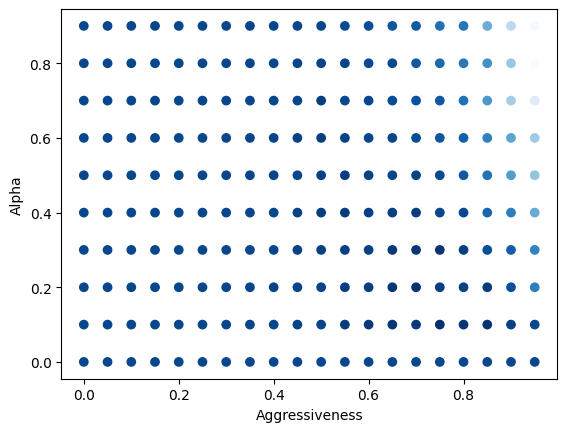

In [61]:
plt.scatter(test_df.aggressiveness, test_df.alpha, 
            c=test_df.average_final_balance, 
            cmap="Blues")
plt.xlabel("Aggressiveness")
plt.ylabel("Alpha")

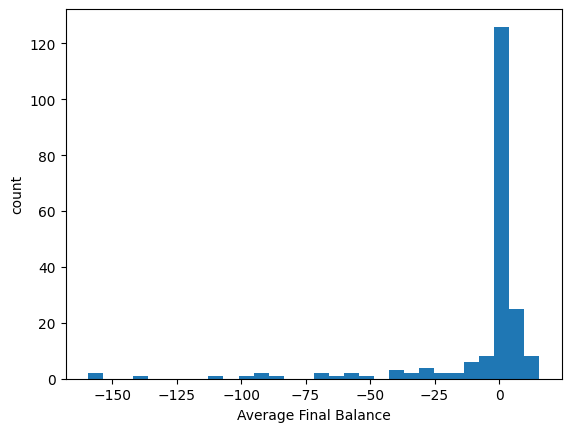

In [64]:
plt.hist(test_df.average_final_balance, bins=30)
plt.xlabel("Average Final Balance")
plt.ylabel("count");

In [59]:
piv_tab = pd.pivot_table(test_df, index="aggressiveness", columns="alpha", fill_value="average_final_balance")
piv_tab

average_final_balance                                   \
alpha                            0.0        0.1        0.2        0.3   
aggressiveness                                                          
0.00                             0.0   0.000000   0.000000   0.000000   
0.05                             0.0   0.000000   0.000000   0.000000   
0.10                             0.0   0.000000   0.530854   0.000000   
0.15                             0.0   0.838746   0.000000   0.118555   
0.20                             0.0   1.742401   0.000000   0.023414   
0.25                             0.0   0.445470  -0.001667   0.007724   
0.30                             0.0   0.000000   1.285914   0.743449   
0.35                             0.0   2.306038   0.874678   0.250937   
0.40                             0.0   0.325861   3.142872   0.557318   
0.45                             0.0   2.507911   2.557777   4.024005   
0.50                             0.0   0.827127   2.098841   4.672890   
0.55                             0.0   6.858239   5.546358   4.735145   
0.60                             0.0   8.366381   5.487804   4.515615   
0.65                             0.0  10.518154  10.724874   9.195613   
0.70                             0.0   8.942463  13.322374  10.640621   
0.75                             0.0  15.543336   5.719828  11.923573   
0.80                             0.0  11.037391   4.511255   5.314098   
0.85                             0.0  13.255604   7.490346  -4.586965   
0.90                             0.0   5.205438  -6.159534 -15.650174   
0.95                             0.0  -0.109042 -36.893496 -39.208114   

                                                                         \
alpha                 0.4        0.5        0.6         0.7         0.8   
aggressiveness                                                            
0.00             0.000000   0.000000   0.000000    0.000000    0.000000   
0.05             0.040348  -0.001224   0.015364    0.011014    0.040742   
0.10             0.084751   0.039453  -0.004903   -0.028333    0.997794   
0.15             0.118052   0.067643   0.017119    1.438938    0.204735   
0.20             0.504350   0.754644   0.010257    0.150931    1.157234   
0.25             0.100193   0.252533   0.204057    1.141533    0.198831   
0.30             1.049380   1.681953   1.550537    0.356228    1.157342   
0.35             0.081054   1.404727   0.696227    0.051294    0.794038   
0.40             0.880620   1.280058   1.888376    0.656409   -0.466703   
0.45             4.544059   0.111444   3.382463    0.076982    1.718796   
0.50             5.705409   3.265680   5.499456    6.191484    2.229432   
0.55             7.086227   5.923130   2.663693   -0.831262    2.334445   
0.60             4.188886   4.009449   0.270218    1.115286   -2.089725   
0.65             4.879854   0.686454   0.659486   -3.251463   -1.432069   
0.70             5.769483   2.796730  -2.915843   -7.648685  -12.040644   
0.75             0.075843  -1.667250 -11.079496  -12.347347  -22.937443   
0.80            -0.427024 -12.699307 -17.118033  -29.452545  -33.269134   
0.85           -21.185485 -29.034568 -38.045663  -55.206381  -49.424415   
0.90           -37.063709 -57.540673 -64.936348  -97.918822  -91.985563   
0.95           -69.452964 -88.839347 -94.954070 -137.250107 -159.279608   

                            
alpha                  0.9  
aggressiveness              
0.00              0.000000  
0.05              0.058743  
0.10              0.141745  
0.15              0.695745  
0.20              0.832992  
0.25              0.255405  
0.30              1.077138  
0.35              0.657923  
0.40              0.690275  
0.45              0.825099  
0.50              1.010651  
0.55             -2.213989  
0.60             -3.679352  
0.65            -10.158375  
0.70            -13.269153  
0.75            -27.885551  
0.80            -31.033810  
0.85            -71.063776  


<Axes: xlabel='None-alpha', ylabel='aggressiveness'>

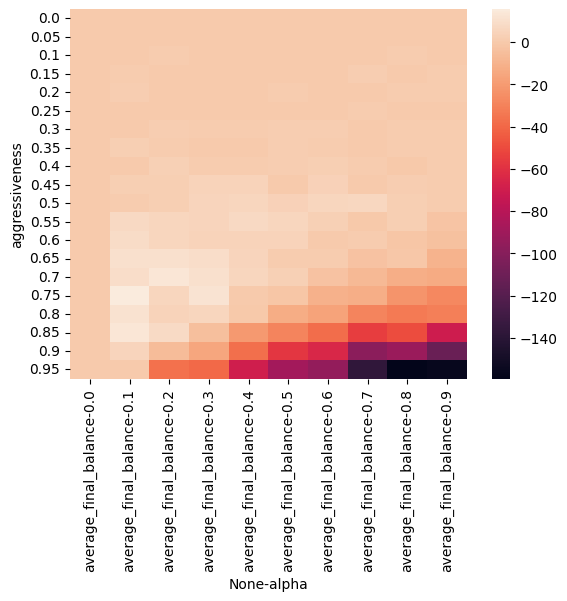

In [60]:
import seaborn as sns

sns.heatmap(piv_tab)

These results are actually somewhat insightful. We can see a small pocket of success and a large corner of failure in the heatmap.